# Python implementation of sounding analysis

In this exercise, you will repeat the sounding analysis from Week 2 using a Jupyter notebook

The first step is to load some packages. Don't worry too much about these at the moment. If you're using the Jupyter hub, everything is installed for you, and you can ignore the next instruction.

If you decide to install Jupyter notebooks locally on your computer, you can install the packages from within a cell as follows:

import sys
!{sys.executable} -m pip install [package name]

Note that pandas, numpy, datetime and matplotlib will probably be automatically installed with jupyter notebooks, but you will probably need to install metpy.


<b> Just run these next two cells with the triangle 'play' button in the menu </b>

In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
from matplotlib import pyplot as plt

In [2]:
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
import metpy.constants as mpconst

In [3]:
# Change default to be better for skew-T
plt.rcParams['figure.figsize'] = (9, 7)

<b> Now we're going to load the sounding data. Remember to copy the file 'sounding_data.csv' into the same directory as this notebook (in your local directory, NOT in the workbooks directory). </b>

In [4]:
SoundingData = pd.read_csv('sounding_data.csv', sep=',', skiprows=4,
names = ['pressure', 'height', 'temperature', 'dewpoint', 'rh', 'w'], engine='python')
SoundingData.head()

,pressure,height,temperature,dewpoint,rh,w
0,996,145,27.0,16.0,51,11.61
1,936,685,22.2,13.2,57,10.29
2,925,787,22.4,11.4,50,9.23
3,921,825,22.4,10.4,47,8.67
4,873,1286,18.4,9.7,57,8.74


In [5]:
# Assign units to your data

hgt = SoundingData['height'].values * units.m
p = SoundingData['pressure'].values * units.hPa
T = SoundingData['temperature'].values * units.degC
Td = SoundingData['dewpoint'].values * units.degC

In [6]:
# Let's have a look to see if it's loaded properly: 

print(SoundingData)

    pressure  height  temperature  dewpoint   rh      w
0        996     145         27.0      16.0   51  11.61
1        936     685         22.2      13.2   57  10.29
2        925     787         22.4      11.4   50   9.23
3        921     825         22.4      10.4   47   8.67
4        873    1286         18.4       9.7   57   8.74
5        850    1516         16.4       9.4   63   8.78
6        797    2060         11.2       8.8   85   8.99
7        776    2283          9.9       6.9   82   8.10
8        775    2294          9.8       6.8   82   8.06
9        771    2337         10.2       0.2   50   5.06
10       761    2445         10.0      -3.0   40   4.05
11       754    2522          9.4       1.4   57   5.65
12       746    2610          9.0       0.8   57   5.48
13       712    2996          7.2      -1.7   53   4.78
14       705    3078          6.8      -2.2   53   4.64
15       700    3136          6.8      -7.2   36   3.20
16       693    3219          6.6     -12.4   24

The LCL pressure is 847.9 hectopascal
The LCL temperature is 13.5 degree_Celsius
The LCL mixing ratio is 11.6 dimensionless


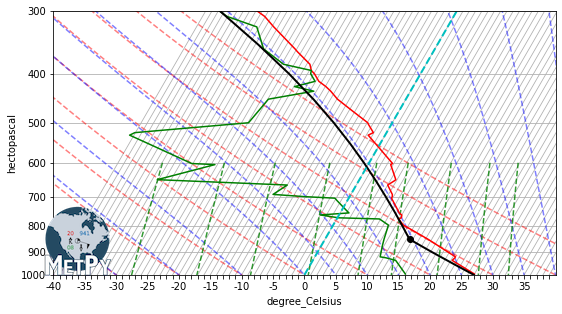

In [9]:
fig = plt.figure(figsize=(9, 7))

# Set up a skewT axis
skew = SkewT(fig=fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(SoundingData.pressure, SoundingData.temperature, 'r')
skew.plot(SoundingData.pressure, SoundingData.dewpoint, 'g')
# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(1000, 300)
# Add xticks at every 1 degree.
xtick_locations = np.arange(-40, 40, 1)
skew.ax.set_xticks(xtick_locations)
# Only want to label every with tick
xtick_labels = [''] * len(xtick_locations)
xtick_labels[::5] = xtick_locations[::5].astype(str)
skew.ax.set_xticklabels(xtick_labels)
skew.ax.set_xlim(-40, 40)

# Add the MetPy logo (just for fun)
add_metpy_logo(fig, 40, 35)

# Let's find the LCL pressure and temperature, and add them to the plot as a black dot:
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
lcl_mixing_ratio = mpcalc.saturation_mixing_ratio(lcl_pressure, lcl_temperature) * 1000 # g/kg

# Print out the properties of the surface parcel at the LCL
print(f'The LCL pressure is {lcl_pressure:.1f}')
print(f'The LCL temperature is {lcl_temperature:.1f}')
print(f'The LCL mixing ratio is {lcl_mixing_ratio:.1f}')

# Mark the LCL on the skewT plot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof_pressures = np.arange(1000,200,-50) * units.hPa

prof = mpcalc.parcel_profile(prof_pressures, T[0], Td[0]).to('degC')

skew.plot(prof_pressures, prof, 'k', linewidth=2)
#skew.plot(prof_pressures, prof1, 'k', linewidth=3)

skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

In [10]:
# We're going to find the closest height level to the 2000m, which is the top of the mountain.
mountain_top = 800 * units.hPa

closest_pressure = min(prof_pressures, key=lambda x:abs(x-mountain_top))
mountain_top_arg = np.argwhere(prof_pressures == closest_pressure)

print(mountain_top_arg, prof_pressures[mountain_top_arg])

[[4]] [[800]] hectopascal


We've just found out the index of the 800 hPa pressure level in the profile. Now we can bring the parcel back to the surface, just like we did manually last week. 

In [11]:
# The saturation vapour pressure. This is the same as the vapour pressure 
# at this point, because the parcel is still saturated.

es_top = mpcalc.saturation_vapor_pressure(prof[mountain_top_arg]) # Pa
print(f'The vapour pressure at the mountain top is {es_top:.1f}')

The vapour pressure at the mountain top is [[13.2]] millibar


In [12]:
# Convert to mixing ratio. This will be conserved when the parcel returns to the surface
w = mpcalc.mixing_ratio(es_top, prof_pressures[mountain_top_arg]) * 1000 # g/kg
print(f'The mixing ratio after descent is {w:.1f}')

The mixing ratio after descent is [[10.4]] dimensionless


In [13]:
# Now we need the saturation mixing ratio. To find this, we need to bring the parcel adiabatically 
# to the surface. This will conserve the potential temperature, so let's just find the potential
# temperature!

TK = prof[mountain_top_arg].to('degK')
P0 = 1000*units.hPa

potential_temperature_top = (TK * np.power((P0 / prof_pressures[mountain_top_arg]),0.286)).to('degC') 

print(f'The potential temperature at the mountain top is {potential_temperature_top:.1f}')

The potential temperature at the mountain top is [[29.8]] degree_Celsius


In [14]:
# The potential temperature at 1000 hPa is the same as the potential temperature at the 
# mountain top. And at 1000hPa, the potential temperature is the same as the temperature.

temperature_at_1000hPa = potential_temperature_top

es = mpcalc.saturation_vapor_pressure(temperature_at_1000hPa) # Pa
print(f'The saturation vapour pressure after descent is {es:.1f}')

The saturation vapour pressure after descent is [[42.1]] millibar


In [15]:
# Saturation mixing ratio at 1000 hPa

ws = mpcalc.mixing_ratio(es, 1000 * units.hPa) * 1000 # g/kg
print(f'The mixing ratio after descent is {ws:.1f}')

The mixing ratio after descent is [[27.3]] dimensionless


In [16]:
# Relative humidity: You do this bit!!!

RH = 100 * w / ws
print(RH)

[[38.23864159110212]] dimensionless


# CHALLENGE #

Use the hydrostatic equation to check the height calculations in the sounding file. 

$ \frac{\partial P}{\partial z} = -\rho g $

Rewrite this as:

$ \Delta z = \frac{-1}{\rho g} \Delta P $

You'll need to start by calculating $\rho$

Then calculate $\Delta z$ for each pair of pressures, and sequentally add to the previous height (ie. use a for loop)

Hints: 
1. Use the first height from the sounding as your h[0]
2. For a more accurate result, calculate $\rho$ in the middle of each layer (ie. the average of the upper and lower values


Finally, make a plot of your height calculation against the one in the sounding file. Are they the same? 

In [17]:
p.shape[0]

40

In [18]:
nlevs = np.shape(p)[0]
#print(nlevs)
rho = (p.to('Pa') / (mpconst.dry_air_gas_constant * (T.to('degK')))).to_base_units()
rho_half_levs = (rho[0:(nlevs -1)] + rho[1:nlevs]) / 2

#print(rho)

hcalc = np.zeros(nlevs)
hcalc[0] = hgt[0].magnitude

for n in range(nlevs-1):
    deltaP = p[n+1] - p[n]
    deltaz = (-1 / (rho_half_levs[n] * mpconst.earth_gravity)) * deltaP.to('Pa')
    
    hcalc[n+1] = hcalc[n] + deltaz.magnitude
    

print(hcalc)
print(hgt)

[ 145.          686.42647018  788.65978979  826.15038484 1286.00756731
 1513.06792748 2053.75074226 2275.48050258 2286.16213796 2329.0494801
 2437.28633773 2513.7942419  2601.9500677  2985.92684712 3066.94516128
 3125.26780838 3207.59362256 3556.59780974 3717.77359421 3755.48072604
 4313.74914716 4354.03208546 4979.23730362 5389.44562315 5479.84465376
 5788.25764845 5835.42058077 6253.49973548 6672.16237608 6949.723705
 7109.47916118 7290.03331077 7548.7547712  7661.93832182 7873.32063391
 8291.03261349 8393.29765268 9119.95935769 9459.89741569 9646.42763303]
[ 145  685  787  825 1286 1516 2060 2283 2294 2337 2445 2522 2610 2996 3078 3136 3219 3568 3730 3767 4327 4367 4990 5403 5494 5803 5850 6264 6685 6962 7121 7302 7560 7673 7885 8303 8406 9133 9473 9660] meter


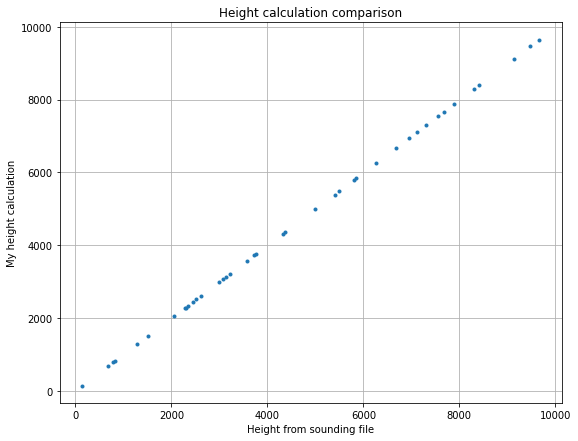

In [19]:
# Let's make a plot! First we need to load another package
import matplotlib.pyplot as plt

# Define som axes
ax = plt.axes()

# Do the plot. Change the axis labels, title and filename to something sensible

ax.plot(hgt, hcalc, '.')

ax.set(xlabel='Height from sounding file', ylabel='My height calculation',
       title='Height calculation comparison')
ax.grid()

#fig.savefig("yourplotname.png")
plt.show()